In [ ]:
import sys
sys.executable
import os
os.getcwd()
sys.path.append('devel/lib/python3/dist-packages/theconstruct_msgs/msg/')
sys.path.append('/home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/src')
sys.path.append('/home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/src/moveo_training/scripts')
sys.path.append('/home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/devel/lib/python3/dist-packages/openai_ros/msg')

In [ ]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import os
import reverb
import tempfile
import PIL.Image

import tensorflow as tf
import moveo_inverse_kinematic
from tf_agents.environments import suite_gym
from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.environments import suite_pybullet
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.policies import policy_saver
from tf_agents.policies import tf_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils

import rospy
from gym.envs.registration import register
import gym
tempdir = tempfile.gettempdir()
from tf_agents.policies import policy_saver
from tf_agents.policies import tf_py_policy
from tf_agents.utils import common

In [ ]:
num_iterations = 10000 # @param {type:"integer"}
initial_collect_steps = 500# @param {type:"integer"}
collect_steps_per_iteration = 1# @param {type:"integer"}
replay_buffer_capacity = 1000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 100# @param {type:"integer"}

num_eval_episodes = 5# @param {type:"integer"}
eval_interval = 100 # @param {type:"integer"}

policy_save_interval = 1000 # @param {type:"integer"}

In [ ]:
rospy.init_node("train_moveo")
env_name = 'MoveoIK-v0' # @param {type:"string"}
env = suite_gym.load('MoveoIK-v0')


In [ ]:
env.reset()

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

In [ ]:
collect_env = suite_gym.load(env_name)
eval_env = suite_gym.load(env_name)

In [ ]:
use_gpu = True
strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

In [ ]:
observation_spec, action_spec, time_step_spec = (
      spec_utils.get_tensor_specs(collect_env))

In [ ]:
with strategy.scope():
  critic_net = critic_network.CriticNetwork(
        (observation_spec, action_spec),
        observation_fc_layer_params=None,
        action_fc_layer_params=None,
        joint_fc_layer_params=critic_joint_fc_layer_params,
        kernel_initializer='glorot_uniform',
        last_kernel_initializer='glorot_uniform')

In [ ]:
with strategy.scope():
  actor_net = actor_distribution_network.ActorDistributionNetwork(
      observation_spec,
      action_spec,
      fc_layer_params=actor_fc_layer_params,
      continuous_projection_net=(
          tanh_normal_projection_network.TanhNormalProjectionNetwork))

In [ ]:
with strategy.scope():
  train_step = train_utils.create_train_step()

  tf_agent = sac_agent.SacAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        critic_network=critic_net,
        actor_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=actor_learning_rate),
        critic_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=critic_learning_rate),
        alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=alpha_learning_rate),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.math.squared_difference,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        train_step_counter=train_step)

  tf_agent.initialize()

In [ ]:
rate_limiter=reverb.rate_limiters.SampleToInsertRatio(samples_per_insert=3.0, min_size_to_sample=3, error_buffer=3.0)

In [ ]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

In [ ]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

In [ ]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

In [ ]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [ ]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

In [ ]:
random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

In [ ]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

In [ ]:
initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  train_step,
  steps_per_run=initial_collect_steps,
  observers=[rb_observer])
initial_collect_actor.run()

In [ ]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  train_step,
  steps_per_run=1,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[rb_observer, env_step_metric])

In [ ]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

In [ ]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]
agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

In [ ]:

def get_eval_metrics():
  print("Starte evaluierung")
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  print("Evaluierung beendete")
  return results

metrics = get_eval_metrics()

In [ ]:
def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

In [ ]:
try:
  %%time
except:
  pass


# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]
avg_episodes_length = get_eval_metrics()["AverageEpisodeLength"]
episodes_lengths = [avg_episodes_length]
i =0
for _ in range(num_iterations):
  # Training.
  i +=1
  collect_actor.run()
  loss_info = agent_learner.run(iterations=1)
  
  # Evaluating.
  step = agent_learner.train_step_numpy
  if eval_interval and step % eval_interval == 0:
    metrics = get_eval_metrics()
    log_eval_metrics(step, metrics)
    returns.append(metrics["AverageReturn"])
    episodes_lengths.append(metrics["AverageEpisodeLength"])
  if log_interval and step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))
rb_observer.close()
reverb_server.stop()



In [ ]:
steps = range(0,6800+1 , eval_interval)
# returnscrop = returns[:151]
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()
# returns

/tmp/ipykernel_732673/2327004025.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


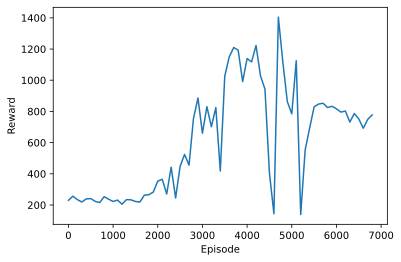

In [40]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')


fig,ax = plt.subplots()
plt.plot(steps,returns )
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.ylim()
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'avgReward_6800E_100S_RewardExplotation.svg'

fig.savefig(image_name, format=image_format, dpi=1200)

In [ ]:
# plt.plot(steps, EpisodeLength)
# plt.ylabel('Episode Length')
# plt.xlabel('Episode')
# plt.ylim()